In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
import scipy as sp
from scipy import stats
from scipy.stats import skew,norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
plt.style.use('seaborn')
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.multicomp import MultiComparison


In [2]:
#read in dataset
df = pd.read_csv('Citywide_Payroll_Data__Fiscal_Year_.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd.set_option('display.max_columns', 999)
df.head()

,Fiscal Year,Payroll Number,Agency Name,Last Name,First Name,Mid Init,Agency Start Date,Work Location Borough,Title Description,Leave Status as of June 30,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay
0,2016,NaN,DISTRICT ATTORNEY-MANHATTAN,ABA'AHMID,RAHASHEEM,E,07/14/2003,MANHATTAN,COMMUNITY ASSOCIATE,ACTIVE,47678.0,per Annum,1830.00,47166.03,2.25,57.28,0.0
1,2016,NaN,DISTRICT ATTORNEY-MANHATTAN,ABENSUR,MARGARET,NaN,06/12/1995,MANHATTAN,ADMINISTRATIVE ACCOUNTANT,ACTIVE,119959.0,per Annum,1831.00,119042.50,0.00,0.00,0.0
2,2016,NaN,DISTRICT ATTORNEY-MANHATTAN,ABOUNAOUM,ANDREA,L,10/11/2011,MANHATTAN,COMMUNITY ASSOCIATE,ON LEAVE,39966.0,per Annum,1181.68,27452.62,1.00,21.34,33.0
3,2016,NaN,DISTRICT ATTORNEY-MANHATTAN,ABRAHAM,JONATHAN,J,12/01/2014,MANHATTAN,COMPUTER SYSTEMS MANAGER,ACTIVE,116000.0,per Annum,1831.00,115104.57,0.00,0.00,0.0
4,2016,NaN,DISTRICT ATTORNEY-MANHATTAN,ABRAMS,JOSEPH,NaN,05/21/2015,MANHATTAN,COLLEGE AIDE,CEASED,1.0,per Hour,0.00,3500.00,0.00,0.00,0.0


# Data Cleaning

In [4]:
#fix issue where 2014 data was stored in column as lowercase (all others were upper)
conditions = [
    df['Work Location Borough'] == 'Manhattan',
    df['Work Location Borough'] == 'Bronx',
    df['Work Location Borough'] == 'Queens',
    df['Work Location Borough'] == 'Brooklyn'
]

choices = [
    'MANHATTAN',
    'BRONX',
    'QUEENS',
    'BROOKLYN'
]

In [5]:
df['Work Location Borough'] = np.select(conditions, choices, df['Work Location Borough'])

In [6]:
df['Work Location Borough'].value_counts()

MANHATTAN        1975270
QUEENS            314933
BROOKLYN          270114
BRONX             150125
OTHER              71698
RICHMOND           38231
WESTCHESTER         2813
ULSTER              1578
SULLIVAN             685
DELAWARE             463
PUTNAM               201
NASSAU               196
SCHOHARIE            145
Richmond             112
DUTCHESS             109
ALBANY                74
GREENE                51
WASHINGTON DC         38
ORANGE                21
Name: Work Location Borough, dtype: int64

In [7]:
# as there is not much data for boroughs other than the following 4, we will drop all those rows
to_keep = ['MANHATTAN', 'QUEENS', 'BROOKLYN', 'BRONX']

In [8]:
df = df[df['Work Location Borough'].isin(to_keep)]

In [9]:
df['Work Location Borough'].value_counts()

MANHATTAN    1975270
QUEENS        314933
BROOKLYN      270114
BRONX         150125
Name: Work Location Borough, dtype: int64

In [10]:
# investigate years and different attributes of salary
df.groupby('Fiscal Year')['Base Salary'].describe()

,count,mean,std,min,25%,50%,75%,max
Fiscal Year,,,,,,,,
2014,3217.0,63540.934405,37827.242763,1.00,37640.00,58500.0,76073.0,197496.0
2015,547677.0,36552.179739,37689.780441,0.50,33.18,35915.0,70850.0,300000.0
2016,520583.0,41094.548718,38784.742285,1.00,33.18,39868.0,76024.0,350000.0
2017,541957.0,41213.288543,40377.730204,0.50,33.18,40411.0,75796.0,350000.0
2018,525778.0,43835.918269,41780.714258,1.00,33.18,42526.5,80000.0,350000.0
2019,571230.0,42936.505432,43021.455534,0.01,33.18,42279.0,78605.0,352763.0


In [11]:
#after investigating mean of all salaries by fiscal year there is much less data for fiscal year 2014, drop that year
df = df[df['Fiscal Year'] != 2014]

In [12]:
df.groupby('Work Location Borough')['Base Salary'].describe()

,count,mean,std,min,25%,50%,75%,max
Work Location Borough,,,,,,,,
BRONX,149190.0,47171.360681,34996.392511,2.79,369.52,46737.0,75954.00,300000.0
BROOKLYN,270114.0,50890.928742,35678.811344,1.00,33799.00,48779.0,76488.00,236088.0
MANHATTAN,1973648.0,37865.767833,41499.314030,0.01,33.18,31320.0,74823.25,352763.0
QUEENS,314273.0,50289.966593,37108.856915,1.00,393.68,49820.0,78026.00,293000.0


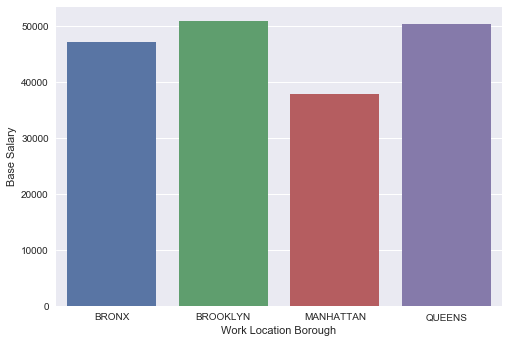

In [13]:
#check to see average salary by Borough, this seems odd and i will investigate further
sns.barplot(x=df.groupby('Work Location Borough')['Base Salary'].median().index, y=df.groupby('Work Location Borough')['Base Salary'].mean())

## clean up year

In [14]:
# getting year person started with city
df['yrs_w_city'] = df['Agency Start Date'].apply(lambda x: x[-4:])


# casting it to an integer
df['yrs_w_city'] = df['yrs_w_city'].astype(int)

# fix issue where people hired on a specific day had year of 9999 instead of 1999
df['yrs_w_city'] = np.where(df['yrs_w_city'] == 9999, 1999,df['yrs_w_city'])

#make column how long they have been with city instead
df['yrs_w_city'] = df['Fiscal Year']-df['yrs_w_city']

#fix issue where there was a guy working for over 100 years and people working (-) years
df = df[(df['yrs_w_city']>=0) & (df['yrs_w_city']<=70)]

In [15]:
df.head()

,Fiscal Year,Payroll Number,Agency Name,Last Name,First Name,Mid Init,Agency Start Date,Work Location Borough,Title Description,Leave Status as of June 30,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay,yrs_w_city
0,2016,NaN,DISTRICT ATTORNEY-MANHATTAN,ABA'AHMID,RAHASHEEM,E,07/14/2003,MANHATTAN,COMMUNITY ASSOCIATE,ACTIVE,47678.0,per Annum,1830.00,47166.03,2.25,57.28,0.0,13
1,2016,NaN,DISTRICT ATTORNEY-MANHATTAN,ABENSUR,MARGARET,NaN,06/12/1995,MANHATTAN,ADMINISTRATIVE ACCOUNTANT,ACTIVE,119959.0,per Annum,1831.00,119042.50,0.00,0.00,0.0,21
2,2016,NaN,DISTRICT ATTORNEY-MANHATTAN,ABOUNAOUM,ANDREA,L,10/11/2011,MANHATTAN,COMMUNITY ASSOCIATE,ON LEAVE,39966.0,per Annum,1181.68,27452.62,1.00,21.34,33.0,5
3,2016,NaN,DISTRICT ATTORNEY-MANHATTAN,ABRAHAM,JONATHAN,J,12/01/2014,MANHATTAN,COMPUTER SYSTEMS MANAGER,ACTIVE,116000.0,per Annum,1831.00,115104.57,0.00,0.00,0.0,2
4,2016,NaN,DISTRICT ATTORNEY-MANHATTAN,ABRAMS,JOSEPH,NaN,05/21/2015,MANHATTAN,COLLEGE AIDE,CEASED,1.0,per Hour,0.00,3500.00,0.00,0.00,0.0,1


## deal with teachers showing up in two rows
###### after looking into teachers salaries thoroughly i found that when they did after school activities they got paid per session and this showed  up in a seperate row, developed a way to add this salary in to the row where yearly salary is and count it as OT as that is essentially what it is

In [16]:
#testing theory with small case
test = df[(df['First Name']=='ADAM') & (df['Last Name']=='GOLDBERG')].sort_values(by = ['Fiscal Year','Agency Start Date'])
test

,Fiscal Year,Payroll Number,Agency Name,Last Name,First Name,Mid Init,Agency Start Date,Work Location Borough,Title Description,Leave Status as of June 30,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay,yrs_w_city
831004,2015,NaN,DEPT OF ED PEDAGOGICAL,GOLDBERG,ADAM,D,09/04/2001,MANHATTAN,TEACHER,ACTIVE,78916.00,per Annum,0.0,79134.45,0.0,0.0,0.00,14
953867,2015,NaN,DEPT OF ED PER SESSION TEACHER,GOLDBERG,ADAM,D,09/04/2001,MANHATTAN,TEACHER- PER SESSION,ACTIVE,33.18,per Day,0.0,40.76,0.0,0.0,0.00,14
953868,2015,NaN,DEPT OF ED PER SESSION TEACHER,GOLDBERG,ADAM,S,09/05/1995,MANHATTAN,TEACHER- PER SESSION,CEASED,33.18,per Day,0.0,19.08,0.0,0.0,1.66,20
831005,2015,NaN,DEPT OF ED PEDAGOGICAL,GOLDBERG,ADAM,S,12/31/9999,MANHATTAN,TEACHER SPECIAL EDUCATION,ACTIVE,100048.00,per Annum,0.0,115956.91,0.0,0.0,0.00,16
288191,2016,NaN,DEPT OF ED PEDAGOGICAL,GOLDBERG,ADAM,D,09/04/2001,MANHATTAN,TEACHER,ACTIVE,81670.00,per Annum,0.0,80082.37,0.0,0.0,0.00,15
288192,2016,NaN,DEPT OF ED PEDAGOGICAL,GOLDBERG,ADAM,S,12/31/1999,MANHATTAN,TEACHER SPECIAL EDUCATION,ACTIVE,108811.00,per Annum,0.0,118101.89,0.0,0.0,0.00,17
1871531,2017,NaN,DEPT OF ED PEDAGOGICAL,GOLDBERG,ADAM,D,09/04/2001,MANHATTAN,TEACHER,ACTIVE,90432.00,per Annum,0.0,87937.01,0.0,0.0,0.00,16
1871532,2017,NaN,DEPT OF ED PEDAGOGICAL,GOLDBERG,ADAM,S,12/31/9999,MANHATTAN,TEACHER SPECIAL EDUCATION,ACTIVE,113762.00,per Annum,0.0,128678.04,0.0,0.0,0.00,18
2378289,2018,742.0,DEPT OF ED PEDAGOGICAL,GOLDBERG,ADAM,D,09/04/2001,MANHATTAN,TEACHER,ACTIVE,94971.00,per Annum,0.0,90923.03,0.0,0.0,0.00,17
2531298,2018,747.0,DEPT OF ED PER SESSION TEACHER,GOLDBERG,ADAM,S,09/05/1995,MANHATTAN,TEACHER- PER SESSION,CEASED,33.18,per Day,0.0,1068.86,0.0,0.0,0.00,23


In [17]:
#shift test dataframe down 1 row
prev_row = test.shift(1)

In [18]:
prev_row.head()

,Fiscal Year,Payroll Number,Agency Name,Last Name,First Name,Mid Init,Agency Start Date,Work Location Borough,Title Description,Leave Status as of June 30,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay,yrs_w_city
831004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
953867,2015.0,NaN,DEPT OF ED PEDAGOGICAL,GOLDBERG,ADAM,D,09/04/2001,MANHATTAN,TEACHER,ACTIVE,78916.00,per Annum,0.0,79134.45,0.0,0.0,0.00,14.0
953868,2015.0,NaN,DEPT OF ED PER SESSION TEACHER,GOLDBERG,ADAM,D,09/04/2001,MANHATTAN,TEACHER- PER SESSION,ACTIVE,33.18,per Day,0.0,40.76,0.0,0.0,0.00,14.0
831005,2015.0,NaN,DEPT OF ED PER SESSION TEACHER,GOLDBERG,ADAM,S,09/05/1995,MANHATTAN,TEACHER- PER SESSION,CEASED,33.18,per Day,0.0,19.08,0.0,0.0,1.66,20.0
288191,2015.0,NaN,DEPT OF ED PEDAGOGICAL,GOLDBERG,ADAM,S,12/31/9999,MANHATTAN,TEACHER SPECIAL EDUCATION,ACTIVE,100048.00,per Annum,0.0,115956.91,0.0,0.0,0.00,16.0


In [19]:
# essentially if the person above has same name and start date we take the regular gross paid column
# and put it into a new column called test
condition = [
    ((test['Last Name'] == prev_row['Last Name']) &
     (test['First Name'] == prev_row['First Name']) &
     (test['Agency Start Date'] == prev_row['Agency Start Date']))
]

choice = [
    (test['Regular Gross Paid'] + prev_row['Total OT Paid'])
]

In [20]:
#if conditions are met the choice is done or else 0 will be put in column
prev_row['test'] = np.select(condition, choice, 0)

In [21]:
prev_row.head()

,Fiscal Year,Payroll Number,Agency Name,Last Name,First Name,Mid Init,Agency Start Date,Work Location Borough,Title Description,Leave Status as of June 30,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay,yrs_w_city,test
831004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
953867,2015.0,NaN,DEPT OF ED PEDAGOGICAL,GOLDBERG,ADAM,D,09/04/2001,MANHATTAN,TEACHER,ACTIVE,78916.00,per Annum,0.0,79134.45,0.0,0.0,0.00,14.0,40.76
953868,2015.0,NaN,DEPT OF ED PER SESSION TEACHER,GOLDBERG,ADAM,D,09/04/2001,MANHATTAN,TEACHER- PER SESSION,ACTIVE,33.18,per Day,0.0,40.76,0.0,0.0,0.00,14.0,0.00
831005,2015.0,NaN,DEPT OF ED PER SESSION TEACHER,GOLDBERG,ADAM,S,09/05/1995,MANHATTAN,TEACHER- PER SESSION,CEASED,33.18,per Day,0.0,19.08,0.0,0.0,1.66,20.0,0.00
288191,2015.0,NaN,DEPT OF ED PEDAGOGICAL,GOLDBERG,ADAM,S,12/31/9999,MANHATTAN,TEACHER SPECIAL EDUCATION,ACTIVE,100048.00,per Annum,0.0,115956.91,0.0,0.0,0.00,16.0,0.00


In [22]:
test.shape

(15, 18)

### scaling to whole df

In [23]:
# group dataframe by the following columns so we make sure if there are multiple people that have two rows
# we can add there 'OT' pay into a new column
df = df.sort_values(by = ['Fiscal Year','Agency Start Date', 'Last Name', 'First Name', 'Mid Init', 'Pay Basis'])
df

,Fiscal Year,Payroll Number,Agency Name,Last Name,First Name,Mid Init,Agency Start Date,Work Location Borough,Title Description,Leave Status as of June 30,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay,yrs_w_city
912183,2015,NaN,DEPT OF ED PER DIEM TEACHERS,KALB,JOANN,NaN,01/01/1969,MANHATTAN,TEACHER-GENERAL ED,ACTIVE,282.76,per Day,0.00,20788.54,0.0,0.0,1.71,46
981470,2015,NaN,DEPT OF ED PER SESSION TEACHER,NACHAMKIN,DENISE,NaN,01/01/1971,MANHATTAN,TEACHER- PER SESSION,CEASED,33.18,per Day,0.00,5756.39,0.0,0.0,0.00,44
992477,2015,NaN,DEPT OF ED PER SESSION TEACHER,RINALDO,ROSANNE,M,01/01/1973,MANHATTAN,TEACHER- PER SESSION,CEASED,33.18,per Day,0.00,10.28,0.0,0.0,0.00,42
666339,2015,NaN,COMMUNITY COLLEGE (LAGUARDIA),REITANO,JOANN,NaN,01/01/1975,QUEENS,PROFESSOR,ACTIVE,58182.00,per Annum,260.72,58022.63,0.0,0.0,0.00,40
759786,2015,NaN,DEPT OF ED HRLY SUPPORT STAFF,WYNN,WILLIAM,H,01/01/1975,MANHATTAN,F/T GROUP LEADER,CEASED,19.47,per Hour,0.00,346.96,0.0,0.0,0.00,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017541,2019,744.0,DEPT OF ED PARA PROFESSIONALS,VELEZ,YOLANDA,NaN,12/31/9999,MANHATTAN,ANNUAL ED PARA,ACTIVE,39830.00,per Annum,0.00,42536.09,0.0,0.0,0.00,20
2904230,2019,742.0,DEPT OF ED PEDAGOGICAL,WALKES,ORDELIA,Y,12/31/9999,MANHATTAN,TEACHER,ACTIVE,121862.00,per Annum,0.00,132599.66,0.0,0.0,0.00,20
3009883,2019,744.0,DEPT OF ED PARA PROFESSIONALS,WHARTON,BRENDA,L,12/31/9999,MANHATTAN,ANNUAL ED PARA,ACTIVE,45203.00,per Annum,0.00,48948.28,0.0,0.0,0.00,20
3009783,2019,744.0,DEPT OF ED PARA PROFESSIONALS,WILLIAMS,CAROLYN,NaN,12/31/9999,MANHATTAN,ANNUAL ED PARA,ACTIVE,45203.00,per Annum,0.00,49013.58,0.0,0.0,0.00,20


In [24]:
#shift dataframe down by 1 row
prev_row = df.shift(1)

In [25]:
# conditions and choices for np.select command
condition = [
    ((df['Last Name'] == prev_row['Last Name']) &
     (df['First Name'] == prev_row['First Name']) &
     (df['Agency Start Date'] == prev_row['Agency Start Date']) &
     (df['Fiscal Year'] == prev_row['Fiscal Year']))
]

choice = [
    (df['Regular Gross Paid'] + prev_row['Total OT Paid'])
]

In [26]:
#make a new column with signifying a different OT protocal
df['OT_2'] = np.select(condition, choice, 0)

In [27]:
# making sure np.select command worked
df.head(50)

,Fiscal Year,Payroll Number,Agency Name,Last Name,First Name,Mid Init,Agency Start Date,Work Location Borough,Title Description,Leave Status as of June 30,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay,yrs_w_city,OT_2
912183,2015,NaN,DEPT OF ED PER DIEM TEACHERS,KALB,JOANN,NaN,01/01/1969,MANHATTAN,TEACHER-GENERAL ED,ACTIVE,282.76,per Day,0.00,20788.54,0.00,0.00,1.71,46,0.00
981470,2015,NaN,DEPT OF ED PER SESSION TEACHER,NACHAMKIN,DENISE,NaN,01/01/1971,MANHATTAN,TEACHER- PER SESSION,CEASED,33.18,per Day,0.00,5756.39,0.00,0.00,0.00,44,0.00
992477,2015,NaN,DEPT OF ED PER SESSION TEACHER,RINALDO,ROSANNE,M,01/01/1973,MANHATTAN,TEACHER- PER SESSION,CEASED,33.18,per Day,0.00,10.28,0.00,0.00,0.00,42,0.00
666339,2015,NaN,COMMUNITY COLLEGE (LAGUARDIA),REITANO,JOANN,NaN,01/01/1975,QUEENS,PROFESSOR,ACTIVE,58182.00,per Annum,260.72,58022.63,0.00,0.00,0.00,40,0.00
759786,2015,NaN,DEPT OF ED HRLY SUPPORT STAFF,WYNN,WILLIAM,H,01/01/1975,MANHATTAN,F/T GROUP LEADER,CEASED,19.47,per Hour,0.00,346.96,0.00,0.00,0.00,40,0.00
663638,2015,NaN,COMMUNITY COLLEGE (LAGUARDIA),ARROYO,GILBERTO,NaN,01/01/1978,QUEENS,PROFESSOR,ACTIVE,116364.00,per Annum,260.72,116045.28,0.00,0.00,0.00,37,0.00
664428,2015,NaN,COMMUNITY COLLEGE (LAGUARDIA),EISENSTADT,BERTON,NaN,01/01/1978,QUEENS,CHIEF COLLEGE LAB TECHNICIAN,ACTIVE,72863.00,per Annum,1825.00,72663.49,0.00,0.00,0.00,37,0.00
664427,2015,NaN,COMMUNITY COLLEGE (LAGUARDIA),EISENSTADT,BERTON,NaN,01/01/1978,QUEENS,ADJUNCT LECTURER,ACTIVE,80.70,per Hour,120.00,14041.80,0.00,0.00,0.00,37,14041.80
658258,2015,NaN,COMMUNITY COLLEGE (HOSTOS),MAKLOUFI,FATIHA,NaN,01/01/1981,BRONX,HIGHER EDUCATION OFFICER,ACTIVE,106071.00,per Annum,1825.00,105780.48,0.00,0.00,0.00,34,0.00
868216,2015,NaN,DEPT OF ED PEDAGOGICAL,PADUANO,JOANNE,M,01/01/1982,MANHATTAN,TEACHER,ACTIVE,100048.00,per Annum,0.00,97295.64,0.00,0.00,0.00,33,0.00


In [28]:
#need to shift 'OT_2' column back up by one so the pay show up in persons yearly earnings row
df['OT_2'] = df['OT_2'].shift(-1)

In [29]:
#checking to make sure it worked
df.head(50)

,Fiscal Year,Payroll Number,Agency Name,Last Name,First Name,Mid Init,Agency Start Date,Work Location Borough,Title Description,Leave Status as of June 30,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay,yrs_w_city,OT_2
912183,2015,NaN,DEPT OF ED PER DIEM TEACHERS,KALB,JOANN,NaN,01/01/1969,MANHATTAN,TEACHER-GENERAL ED,ACTIVE,282.76,per Day,0.00,20788.54,0.00,0.00,1.71,46,0.00
981470,2015,NaN,DEPT OF ED PER SESSION TEACHER,NACHAMKIN,DENISE,NaN,01/01/1971,MANHATTAN,TEACHER- PER SESSION,CEASED,33.18,per Day,0.00,5756.39,0.00,0.00,0.00,44,0.00
992477,2015,NaN,DEPT OF ED PER SESSION TEACHER,RINALDO,ROSANNE,M,01/01/1973,MANHATTAN,TEACHER- PER SESSION,CEASED,33.18,per Day,0.00,10.28,0.00,0.00,0.00,42,0.00
666339,2015,NaN,COMMUNITY COLLEGE (LAGUARDIA),REITANO,JOANN,NaN,01/01/1975,QUEENS,PROFESSOR,ACTIVE,58182.00,per Annum,260.72,58022.63,0.00,0.00,0.00,40,0.00
759786,2015,NaN,DEPT OF ED HRLY SUPPORT STAFF,WYNN,WILLIAM,H,01/01/1975,MANHATTAN,F/T GROUP LEADER,CEASED,19.47,per Hour,0.00,346.96,0.00,0.00,0.00,40,0.00
663638,2015,NaN,COMMUNITY COLLEGE (LAGUARDIA),ARROYO,GILBERTO,NaN,01/01/1978,QUEENS,PROFESSOR,ACTIVE,116364.00,per Annum,260.72,116045.28,0.00,0.00,0.00,37,0.00
664428,2015,NaN,COMMUNITY COLLEGE (LAGUARDIA),EISENSTADT,BERTON,NaN,01/01/1978,QUEENS,CHIEF COLLEGE LAB TECHNICIAN,ACTIVE,72863.00,per Annum,1825.00,72663.49,0.00,0.00,0.00,37,14041.80
664427,2015,NaN,COMMUNITY COLLEGE (LAGUARDIA),EISENSTADT,BERTON,NaN,01/01/1978,QUEENS,ADJUNCT LECTURER,ACTIVE,80.70,per Hour,120.00,14041.80,0.00,0.00,0.00,37,0.00
658258,2015,NaN,COMMUNITY COLLEGE (HOSTOS),MAKLOUFI,FATIHA,NaN,01/01/1981,BRONX,HIGHER EDUCATION OFFICER,ACTIVE,106071.00,per Annum,1825.00,105780.48,0.00,0.00,0.00,34,0.00
868216,2015,NaN,DEPT OF ED PEDAGOGICAL,PADUANO,JOANNE,M,01/01/1982,MANHATTAN,TEACHER,ACTIVE,100048.00,per Annum,0.00,97295.64,0.00,0.00,0.00,33,5150.74


## get rid of workers that make less than full time wages

In [30]:
# making a generalization that to work full time you work around 1500 hours. 
# getting rid of anyone that does not meet that criteria
min_wage = 15*1500
min_hours = 1500

In [31]:
condition = [
    ((df['Regular Gross Paid'] > min_wage) |
     (df['Regular Hours'] > 1500) |
     (df['Base Salary'] > min_wage))
]
 

choice = [
    'keep'
]

In [32]:
#creating a column called drop letting us know to either drop the rows or keep them 
df['drop'] = np.select(condition, choice, 'drop')

In [33]:
df.head()

,Fiscal Year,Payroll Number,Agency Name,Last Name,First Name,Mid Init,Agency Start Date,Work Location Borough,Title Description,Leave Status as of June 30,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay,yrs_w_city,OT_2,drop
912183,2015,NaN,DEPT OF ED PER DIEM TEACHERS,KALB,JOANN,NaN,01/01/1969,MANHATTAN,TEACHER-GENERAL ED,ACTIVE,282.76,per Day,0.00,20788.54,0.0,0.0,1.71,46,0.0,drop
981470,2015,NaN,DEPT OF ED PER SESSION TEACHER,NACHAMKIN,DENISE,NaN,01/01/1971,MANHATTAN,TEACHER- PER SESSION,CEASED,33.18,per Day,0.00,5756.39,0.0,0.0,0.00,44,0.0,drop
992477,2015,NaN,DEPT OF ED PER SESSION TEACHER,RINALDO,ROSANNE,M,01/01/1973,MANHATTAN,TEACHER- PER SESSION,CEASED,33.18,per Day,0.00,10.28,0.0,0.0,0.00,42,0.0,drop
666339,2015,NaN,COMMUNITY COLLEGE (LAGUARDIA),REITANO,JOANN,NaN,01/01/1975,QUEENS,PROFESSOR,ACTIVE,58182.00,per Annum,260.72,58022.63,0.0,0.0,0.00,40,0.0,keep
759786,2015,NaN,DEPT OF ED HRLY SUPPORT STAFF,WYNN,WILLIAM,H,01/01/1975,MANHATTAN,F/T GROUP LEADER,CEASED,19.47,per Hour,0.00,346.96,0.0,0.0,0.00,40,0.0,drop


In [34]:
#checking to see amount of rows to be dropped
df['drop'].value_counts()

keep    1737188
drop     970023
Name: drop, dtype: int64

In [35]:
#setting dataframe to be columns that are full time workers
df = df[df['drop'] == 'keep']

In [36]:
df['drop'].value_counts()

keep    1737188
Name: drop, dtype: int64

In [37]:
# also get rid of people with prorated salaries as we want a full years salary
df = df[df['Pay Basis'] != 'Prorated Annual']

## put peoples salaries in new column as people who work per hour/day show up in regular gross paid and per Annum people show salary in Base Saray Column

In [38]:
#checking amount of people in each Pay Basis 
df['Pay Basis'].value_counts()

per Annum    1578927
per Hour       77512
per Day        70981
Name: Pay Basis, dtype: int64

In [39]:
# setting conditions and choices for np.select
condition = [
    (df['Pay Basis'] == 'per Hour'),
    (df['Pay Basis'] == 'per Day'),
    (df['Pay Basis'] == 'per Annum')
]
 

choice = [
    df['Regular Gross Paid'],
    df['Regular Gross Paid'],
    df['Base Salary']
]

In [40]:
#if person is paid by hour or by day the Gross pay goes into Salary column
#otherwise the Base Salary goes in Salary column
df['Salary'] = np.select(condition, choice, '0')

## get total OT/salary with OT

In [41]:
# get total OT paid for everyone as people may have shown up in two rows
df['Total_OT'] = df['Total OT Paid'] + df['OT_2']

In [42]:
# Change Salary to float
df['Salary'] = df['Salary'].astype(float)

In [43]:
# get total salary (OT + Base)
df['Total Salary'] = df['Salary'] + df['Total_OT']

In [44]:
df.head()

,Fiscal Year,Payroll Number,Agency Name,Last Name,First Name,Mid Init,Agency Start Date,Work Location Borough,Title Description,Leave Status as of June 30,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay,yrs_w_city,OT_2,drop,Salary,Total_OT,Total Salary
666339,2015,NaN,COMMUNITY COLLEGE (LAGUARDIA),REITANO,JOANN,NaN,01/01/1975,QUEENS,PROFESSOR,ACTIVE,58182.0,per Annum,260.72,58022.63,0.0,0.0,0.0,40,0.00,keep,58182.0,0.00,58182.00
663638,2015,NaN,COMMUNITY COLLEGE (LAGUARDIA),ARROYO,GILBERTO,NaN,01/01/1978,QUEENS,PROFESSOR,ACTIVE,116364.0,per Annum,260.72,116045.28,0.0,0.0,0.0,37,0.00,keep,116364.0,0.00,116364.00
664428,2015,NaN,COMMUNITY COLLEGE (LAGUARDIA),EISENSTADT,BERTON,NaN,01/01/1978,QUEENS,CHIEF COLLEGE LAB TECHNICIAN,ACTIVE,72863.0,per Annum,1825.00,72663.49,0.0,0.0,0.0,37,14041.80,keep,72863.0,14041.80,86904.80
658258,2015,NaN,COMMUNITY COLLEGE (HOSTOS),MAKLOUFI,FATIHA,NaN,01/01/1981,BRONX,HIGHER EDUCATION OFFICER,ACTIVE,106071.0,per Annum,1825.00,105780.48,0.0,0.0,0.0,34,0.00,keep,106071.0,0.00,106071.00
868216,2015,NaN,DEPT OF ED PEDAGOGICAL,PADUANO,JOANNE,M,01/01/1982,MANHATTAN,TEACHER,ACTIVE,100048.0,per Annum,0.00,97295.64,0.0,0.0,0.0,33,5150.74,keep,100048.0,5150.74,105198.74


## Change Agency Values

In [45]:
# As can be seen here there are many agencies that are broken down too much when they
# should all fall under one Department. we will clean them up so it reflects one Department
df['Agency Name'].unique()

array(['COMMUNITY COLLEGE (LAGUARDIA)', 'COMMUNITY COLLEGE (HOSTOS)',
       'DEPT OF ED PEDAGOGICAL', 'COMMUNITY COLLEGE (BRONX)',
       'FIRE DEPARTMENT', 'COMMUNITY COLLEGE (KINGSBORO)',
       'DEPT OF ED PARA PROFESSIONALS', 'OFFICE OF THE COMPTROLLER',
       'DEPARTMENT OF EDUCATION ADMIN', 'DEPT OF ED HRLY SUPPORT STAFF',
       'DEPARTMENT OF TRANSPORTATION', 'DEPT OF ED PER SESSION TEACHER',
       'OFFICE OF MANAGEMENT & BUDGET', 'POLICE DEPARTMENT',
       "ADMIN FOR CHILDREN'S SVCS", 'HRA/DEPT OF SOCIAL SERVICES',
       'BOROUGH PRESIDENT-BROOKLYN', 'BOROUGH PRESIDENT-QUEENS',
       'BOROUGH PRESIDENT-BRONX', 'OFFICE OF THE MAYOR', 'LAW DEPARTMENT',
       'LANDMARKS PRESERVATION COMM', 'COMMUNITY COLLEGE (QUEENSBORO)',
       'CITY COUNCIL', 'DEPT OF ED PER DIEM TEACHERS',
       'DEPT. OF HOMELESS SERVICES', 'DEPARTMENT FOR THE AGING',
       'DEPARTMENT OF SANITATION', 'CAMPAIGN FINANCE BOARD',
       'DISTRICT ATTORNEY-MANHATTAN', 'BOARD OF ELECTION POLL WORKERS',
 

In [46]:
# set conditions/chioces for np.select command
conditions = [
    df['Agency Name'].str.contains('COMMUNITY BOARD'),
    df['Agency Name'].str.contains('DEPT OF ED'),
    df['Agency Name'].str.contains('DOE'),
    df['Agency Name'].str.contains('DISTRICT ATTORNEY'),
    df['Agency Name'].str.contains('COMMUNITY COLLEGE'),
    df['Agency Name'].str.contains('BOROUGH PRESIDENT')
]

choices = [
    'COMMUNITY BOARD',
    'DEPARTMENT OF EDUCATION',
    'DEPARTMENT OF EDUCATION',
    'DISTRICT ATTORNEY',
    'COMMUNITY COLLEGE',
    'BOROUGH PRESIDENT'
]

In [47]:
# creates a new column based on the above specified conditions and choices
df['Agency'] = np.select(conditions, choices, df['Agency Name'])

In [48]:
df['Agency'].unique()

array(['COMMUNITY COLLEGE', 'DEPARTMENT OF EDUCATION', 'FIRE DEPARTMENT',
       'OFFICE OF THE COMPTROLLER', 'DEPARTMENT OF EDUCATION ADMIN',
       'DEPARTMENT OF TRANSPORTATION', 'OFFICE OF MANAGEMENT & BUDGET',
       'POLICE DEPARTMENT', "ADMIN FOR CHILDREN'S SVCS",
       'HRA/DEPT OF SOCIAL SERVICES', 'BOROUGH PRESIDENT',
       'OFFICE OF THE MAYOR', 'LAW DEPARTMENT',
       'LANDMARKS PRESERVATION COMM', 'CITY COUNCIL',
       'DEPT. OF HOMELESS SERVICES', 'DEPARTMENT FOR THE AGING',
       'DEPARTMENT OF SANITATION', 'CAMPAIGN FINANCE BOARD',
       'DISTRICT ATTORNEY', 'BOARD OF ELECTION POLL WORKERS',
       'PUBLIC ADVOCATE', 'PRESIDENT BOROUGH OF MANHATTAN',
       'NYC EMPLOYEES RETIREMENT SYS', 'NYC HOUSING AUTHORITY',
       'PUBLIC ADMINISTRATOR-BRONX', 'HOUSING PRESERVATION & DVLPMNT',
       'DEPARTMENT OF CITY PLANNING', 'DEPARTMENT OF PROBATION',
       'DEPT OF HEALTH/MENTAL HYGIENE', 'DEPT OF CITYWIDE ADMIN SVCS',
       'DEPT OF INFO TECH & TELECOMM', 'DEPARTME

# EDA

In [49]:
df.groupby('Agency')['Base Salary'].sum().sort_values(ascending = False)

Agency
DEPARTMENT OF EDUCATION           4.458255e+10
POLICE DEPARTMENT                 1.987817e+10
FIRE DEPARTMENT                   6.274013e+09
DEPARTMENT OF CORRECTION          4.480533e+09
DEPARTMENT OF EDUCATION ADMIN     4.027097e+09
                                      ...     
CIVIL SERVICE COMMISSION          3.254716e+06
PUBLIC ADMINISTRATOR-BRONX        3.251470e+06
PUBLIC ADMINISTRATOR-QUEENS       2.911705e+06
PERSONNEL MONITORS                8.150000e+02
BOARD OF ELECTION POLL WORKERS    1.900000e+01
Name: Base Salary, Length: 77, dtype: float64

Text(0.5, 0, 'Sum of Salaries')

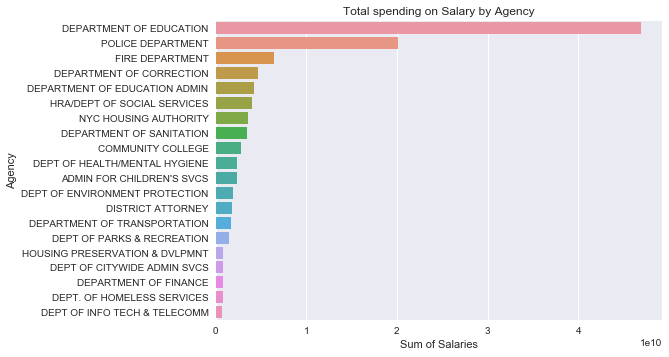

In [50]:
# inspect total spending by agency, as we can see from this graph the Department of Education abd Police Department
# eclips al other departments in total spending
spending = df.groupby('Agency')['Salary'].sum().sort_values(ascending = False)[:20]
sns.barplot(x=spending, y=spending.keys())
plt.title('Total spending on Salary by Agency')
plt.xlabel('Sum of Salaries')

Text(0.5, 0, 'Average Salary')

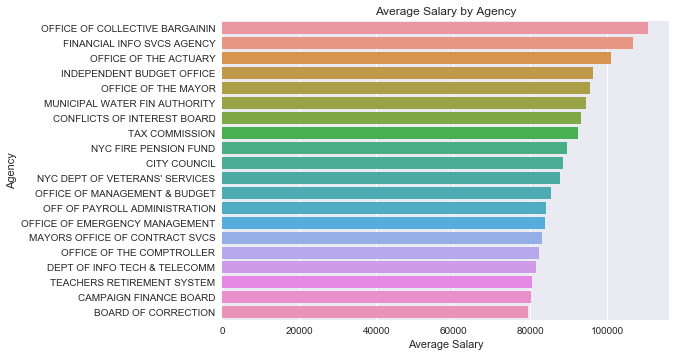

In [51]:
# inspect Agencies that have the highest average salary
spending = df.groupby('Agency')['Salary'].mean().sort_values(ascending = False)[:20]
sns.barplot(x=spending, y=spending.keys())
plt.title('Average Salary by Agency')
plt.xlabel('Average Salary')

Text(0.5, 1.0, 'Average Salary by Year')

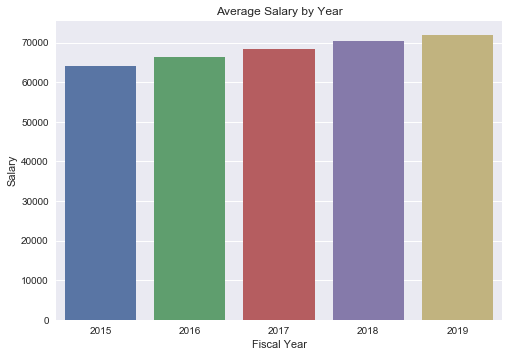

In [52]:
sns.barplot(x=df.groupby('Fiscal Year')['Salary'].mean().index, y=df.groupby('Fiscal Year')['Salary'].mean())
plt.title('Average Salary by Year')

(0, 61)

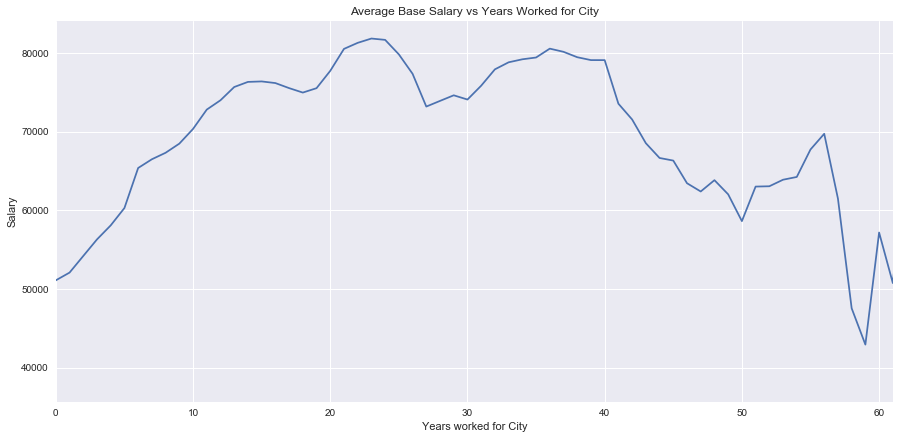

In [53]:
#from this plot we can see that just after 20 years worked for the city the salary starts to be stagnant
#for around 20 years, then it starts to drop off dramatically
fig, ax = plt.subplots(figsize=(15,7))
df.groupby('yrs_w_city')['Salary'].mean().plot(ax=ax)
ax.set_ylabel('Salary')
ax.set_xlabel('Years worked for City')
ax.set_title('Average Base Salary vs Years Worked for City')
plt.xlim(0, 61)

## Hypothesis Test 1

Is there a statistically significant difference between the average salaries of the two biggest spending departments

Null Hypothesis: there is no difference between average salaries for two biggest spending departments

Alternative Hypothesis: there is a statistical difference between the average salaries for the two biggest spending departments

In [54]:
Police_salaries = df[df['Agency'] == 'POLICE DEPARTMENT']['Salary']

In [55]:
Teacher_salaries = df[df['Agency'] == 'DEPARTMENT OF EDUCATION']['Salary']

In [56]:
import scipy.stats as stats
stats.ttest_ind(Teacher_salaries,Police_salaries)

Ttest_indResult(statistic=-43.23411959234426, pvalue=0.0)

## Hypothesis Test 2

Is there a statistically significant differrence between a persons salary and the borough they work in

Null Hypothesis: There is no diffeernce between the borough you work in and your salary

Alternative Hypothesis: there is a statistically significant difference between what borough you work in and your salary

In [57]:
stats.f_oneway(df['Salary'][df['Work Location Borough'] == 'MANHATTAN'],
               df['Salary'][df['Work Location Borough'] == 'BRONX'],
               df['Salary'][df['Work Location Borough'] == 'QUEENS'],
               df['Salary'][df['Work Location Borough'] == 'BROOKLYN'])

F_onewayResult(statistic=2307.4919365339597, pvalue=0.0)

As we can see from this Annova test our p-value is very small meaning that we would reject the null hypothesis. This test only tells us that at least one of the boroughs has a statistically different salary from the others. To see which ones are dofferent from each other we must do a Multicomparison test.

In [58]:
mc = MultiComparison(df['Salary'],df['Work Location Borough'])
mc_results = mc.tukeyhsd()
mc_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
BRONX,BROOKLYN,2193.3909,0.001,1928.28,2458.5019,True
BRONX,MANHATTAN,5883.5336,0.001,5657.4822,6109.5851,True
BRONX,QUEENS,4057.0403,0.001,3797.4301,4316.6505,True
BROOKLYN,MANHATTAN,3690.1427,0.001,3520.354,3859.9315,True
BROOKLYN,QUEENS,1863.6494,0.001,1651.2196,2076.0792,True
MANHATTAN,QUEENS,-1826.4933,0.001,-1987.5581,-1665.4286,True


From the MultiComparison test we see that we will reject the null hypothesis for every comparison in the chart. 

Text(0.5, 1.0, 'Average Salary by Borough')

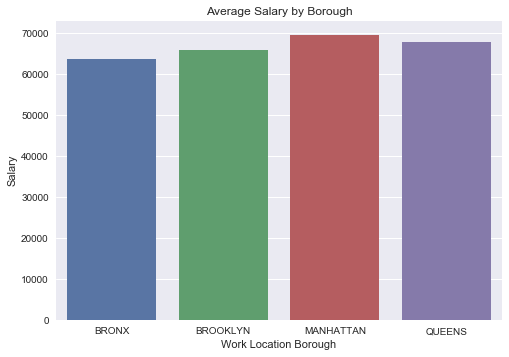

In [59]:
sns.barplot(x=df.groupby('Work Location Borough')['Salary'].mean().index, y=df.groupby('Work Location Borough')['Salary'].mean())
plt.title('Average Salary by Borough')

## Hypothesis Test 3

Is there a difference between the salaries of people who are payed by the hour, day, or year

Null Hypothesis: there is no difference between the salary of people who are payed by the hour, day or year

Alternative Hypothesis: there is a statistically significant difference between people who are payed by the hour, day, or year

In [60]:
stats.f_oneway(df['Salary'][df['Pay Basis'] == 'per Annum'],
               df['Salary'][df['Pay Basis'] == 'per Day'],
               df['Salary'][df['Pay Basis'] == 'per Hour'])

F_onewayResult(statistic=47368.37574463216, pvalue=0.0)

From the Annova test we know that at least one categories salary is statistically different from the others. To further explore the relationships between each category we will do a MultiComparison test.

In [61]:
mc = MultiComparison(df['Salary'],df['Pay Basis'])
mc_results = mc.tukeyhsd()
mc_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
per Annum,per Day,-7634.5138,0.001,-7886.2071,-7382.8205,True
per Annum,per Hour,-31134.0805,0.001,-31375.4132,-30892.7478,True
per Day,per Hour,-23499.5667,0.001,-23840.3603,-23158.7731,True


From the multicomparison test we can conclude that we can reject the null hypothesis for every single comparison. Plotting the salaries by day, hour, and year further solidifies that there is a big difference between these categories.

Text(0.5, 1.0, 'Average Salary by Pay Basis')

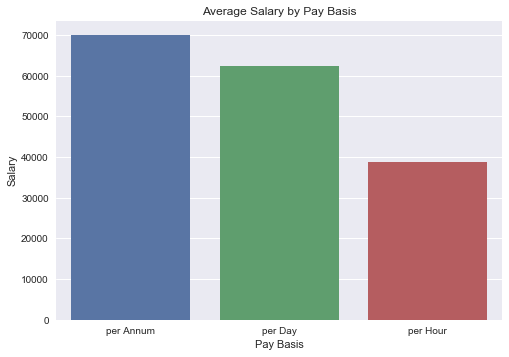

In [62]:
sns.barplot(x=df.groupby('Pay Basis')['Salary'].median().index, y=df.groupby('Pay Basis')['Salary'].mean())
plt.title('Average Salary by Pay Basis')

# Feature Selection

exploring relationships between certain variable and Salary

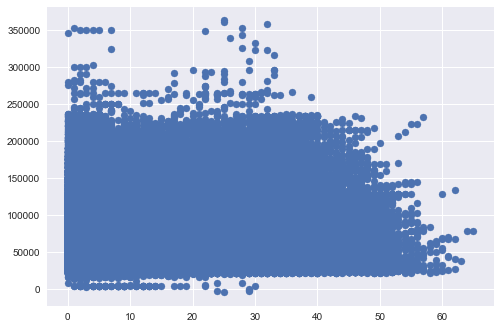

In [63]:
plt.scatter(df['yrs_w_city'], df['Salary'])

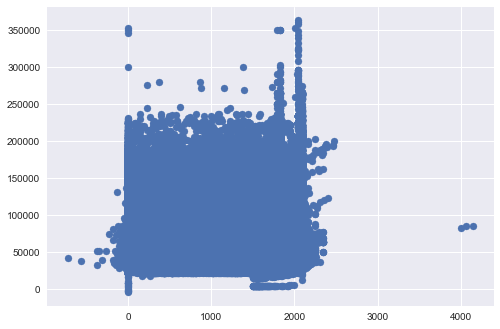

In [64]:
plt.scatter(df['Regular Hours'], df['Salary'])

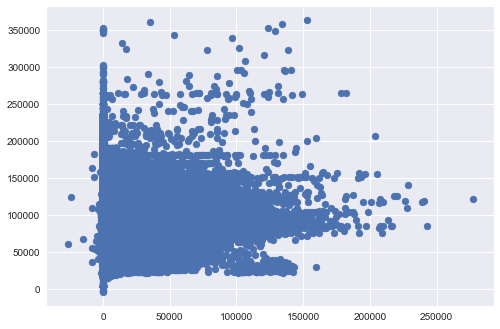

In [65]:
plt.scatter(df['Total_OT'], df['Salary'])

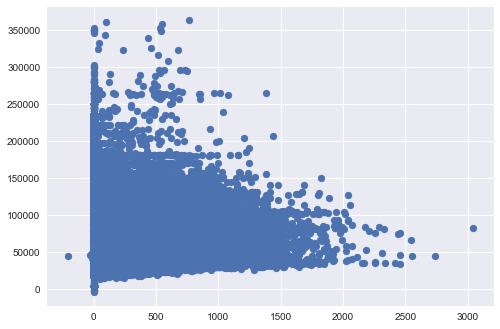

In [66]:
plt.scatter(df['OT Hours'], df['Salary'])

In [67]:
# replace empty spaces in column names
df.columns = df.columns.str.replace(' ', '_')

In [68]:
# drop columns we don't want anymore
to_drop = ['Payroll_Number','Agency_Name','Last_Name','First_Name','Mid_Init','Agency_Start_Date','Leave_Status_as_of_June_30','drop','Regular_Gross_Paid','Base_Salary','Total_Salary', 'Total_OT_Paid', 'OT_2']
df.drop(columns= to_drop, inplace = True)

In [69]:
df.head()

,Fiscal_Year,Work_Location_Borough,Title_Description,Pay_Basis,Regular_Hours,OT_Hours,Total_Other_Pay,yrs_w_city,Salary,Total_OT,Agency
666339,2015,QUEENS,PROFESSOR,per Annum,260.72,0.0,0.0,40,58182.0,0.00,COMMUNITY COLLEGE
663638,2015,QUEENS,PROFESSOR,per Annum,260.72,0.0,0.0,37,116364.0,0.00,COMMUNITY COLLEGE
664428,2015,QUEENS,CHIEF COLLEGE LAB TECHNICIAN,per Annum,1825.00,0.0,0.0,37,72863.0,14041.80,COMMUNITY COLLEGE
658258,2015,BRONX,HIGHER EDUCATION OFFICER,per Annum,1825.00,0.0,0.0,34,106071.0,0.00,COMMUNITY COLLEGE
868216,2015,MANHATTAN,TEACHER,per Annum,0.00,0.0,0.0,33,100048.0,5150.74,DEPARTMENT OF EDUCATION


In [70]:
# create dummy variables for Agency, Pay Basis, Work Location, and Title Description
df = pd.get_dummies(df, columns = ['Agency'],drop_first=True)
df = pd.get_dummies(df, columns = ['Pay_Basis'],drop_first=True)
df = pd.get_dummies(df, columns = ['Work_Location_Borough'],drop_first=True)
df = pd.get_dummies(df, columns = ['Title_Description'],drop_first=True)

In [71]:
#get rid of characters that would not let OLS model run
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('.', '')
df.columns = df.columns.str.replace('/', '_')
df.columns = df.columns.str.replace('&', '_')
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace('-', '_')
df.columns = df.columns.str.replace('*', '')
df.columns = df.columns.str.replace(',', '')
df.columns = df.columns.str.replace('?', '')
df.columns = df.columns.str.replace(':', '')
df.columns = df.columns.str.replace('#', '')
df.columns = df.columns.str.replace(')', '')
df.columns = df.columns.str.replace('(', '')
df.columns = df.columns.str.replace('<', '')
df.columns = df.columns.str.replace('>', '')

In [72]:
# create a list of columns of dataframe
cols = list(df.columns)

In [73]:
#start a feature list to use in an ols model
feature_list = []
for col in cols:
    if 'Title_Description' not in col:
        feature_list.append(col)  

In [74]:
# initiate string to be used for all features in model
feature_string = 'Salary ~  yrs_w_city'

In [75]:
# remove features from feature list that we intialized in feature_string
feature_list.remove('Salary')
feature_list.remove('yrs_w_city')

In [76]:
#loops through feature_list and adds that feature to the feature_string
for feature in feature_list:
    feature_string = feature_string + f' + {feature}'

In [77]:
# take a first look at a model
df_test = ols(formula=feature_string, data=df).fit()
df_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     8238.
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:42:18   Log-Likelihood:            -1.9885e+07
No. Observations:             1727420   AIC:                         3.977e+07
Df Residuals:                 1727332   BIC:                         3.977e+07
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                             -3.543e+06   2.63e+04   -134.732      0.000   -3.59e+06   -3.49e+06
yrs_w_city                              791.2060      2.134    370.694      0.000     787.023     795.389
Fiscal_Year                            1779.8259     13.038    136.508      0.000    1754.271    1805.380
Regular_Hours                             4.1462      0.045     91.127      0.000       4.057       4.235
OT_Hours                                -77.8427      0.228   -341.264      0.000     -78.290     -77.396
Total_Other_Pay                           0.5502      0.004    127.416      0.000       0.542       0.559
Total_OT                                  1.3176      0.003    391.984      0.000       1.311       1.324
Agency_ADMIN_TRIALS_AND_HEARINGS       9289.3196    477.716     19.445      0.000    8353.013    1.02e+04
Agency_BOARD_OF_CORRECTION             1.353e+04   2068.871      6.539      0.000    9473.564    1.76e+04
Agency_BOARD_OF_ELECTION                 86.0204    447.641      0.192      0.848    -791.341     963.382
Agency_BOARD_OF_ELECTION_POLL_WORKERS -1360.9793   5546.953     -0.245      0.806   -1.22e+04    9510.856
Agency_BOROUGH_PRESIDENT               9215.1884    763.641     12.067      0.000    7718.479    1.07e+04
Agency_BUSINESS_INTEGRITY_COMMISSION   5948.0371   1095.110      5.431      0.000    3801.660    8094.414
Agency_CAMPAIGN_FINANCE_BOARD          1.793e+04    987.912     18.148      0.000     1.6e+04    1.99e+04
Agency_CITY_CLERK                     -7649.1877   1248.052     -6.129      0.000   -1.01e+04   -5203.050
Agency_CITY_COUNCIL                    2.391e+04    555.012     43.077      0.000    2.28e+04     2.5e+04
Agency_CIVIL_SERVICE_COMMISSION        2.473e+04   3023.896      8.177      0.000    1.88e+04    3.07e+04
Agency_CIVILIAN_COMPLAINT_REVIEW_BD    6603.1509    718.695      9.188      0.000    5194.533    8011.768
Agency_COMMUNITY_BOARD                 -832.2226    814.594     -1.022      0.307   -2428.798     764.353
Agency_COMMUNITY_COLLEGE               1960.0004    174.895     11.207      0.000    1617.213    2302.788
Agency_CONFLICTS_OF_INTEREST_BOARD      2.78e+04   2032.281     13.679      0.000    2.38e+04    3.18e+04
Agency_CONSUMER_AFFAIRS               -2201.9418    510.792     -4.311      0.000   -3203.076   -1200.807
Agency_CULTURAL_AFFAIRS                1.197e+04   1248.291      9.592      0.000    9526.770    1.44e+04
Agency_CUNY_CENTRAL_OFFICE             8189.6400   1863.735      4.394      0.000    4536.784    1.18e+04
Agency_DEPARTMENT_FOR_THE_AGING         903.2841    588.965      1.534      0.125    -251.067    2057.635
Agency_DEPARTMENT_OF_BUILDINGS         8295.4122    299.733     27.676      0.000    7707.946    8882.878
Agency_DE

### Look into other features we can add

In [78]:
# get list of all job titles
Title_features = []
for col in cols:
    if 'Title_Description' in col:
        Title_features.append(col)  

In [79]:
# find r_squared for all job titles compared to salary
r_squared = [ols(formula='Salary~{}'.format(x), data=df).fit().rsquared for x in Title_features]

In [80]:
#create a dictionary with feature and its corresponding r_squared
data = dict(zip(Title_features,r_squared))

#sort by r_squared values
data = {k: v for k, v in sorted(data.items(), key=lambda item: item[1], reverse = True)}
data

{'Title_Description_ANNUAL_ED_PARA': 0.11734539781471542,
 'Title_Description_TEACHER': 0.04857348495281966,
 'Title_Description_PRINCIPAL': 0.0296305870936866,
 'Title_Description_ASSISTANT_PRINCIPAL': 0.02307852681139666,
 'Title_Description_F_T_SCHOOL_AIDE': 0.02285738072179999,
 'Title_Description_LIEUTENANT': 0.018217275327934712,
 'Title_Description_COMPUTER_SYSTEMS_MANAGER': 0.016285057148712867,
 'Title_Description_SCHOOL_SAFETY_AGENT': 0.015290381317320967,
 'Title_Description_CAPTAIN': 0.01252367427512835,
 'Title_Description_TEACHER_GENERAL_ED': 0.01236331372964139,
 'Title_Description_CLERICAL_ASSOCIATE': 0.012187632877737054,
 'Title_Description_COMMUNITY_ASSOCIATE': 0.011538719360054905,
 'Title_Description_CARETAKER': 0.011242679365442654,
 'Title_Description_F_T_SCHOOL_LUNCH_HELPER': 0.010441889366601842,
 'Title_Description_F_T_SR_SCHOOL_LUNCH_HELPER': 0.010153140224981372,
 'Title_Description_ADMINISTRATIVE_STAFF_ANALYST': 0.009811141501364307,
 'Title_Description_TEA

In [81]:
# add top 25 features by r_squared into model
n=0
for key in data.keys():
    if n == 25:
        break
    else:
        feature_list.append(key)
        n+=1 

In [82]:
feature_string = 'Salary ~  yrs_w_city'
for feature in feature_list:
    feature_string = feature_string + f' + {feature}'

In [83]:
df_test = ols(formula=feature_string, data=df).fit()
df_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                 2.181e+04
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:49:21   Log-Likelihood:            -1.9424e+07
No. Observations:             1727420   AIC:                         3.885e+07
Df Residuals:                 1727307   BIC:                         3.885e+07
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                          -3.916e+06   2.02e+04   -193.487      0.000   -3.96e+06   -3.88e+06
yrs_w_city                                           759.7546      1.657    458.392      0.000     756.506     763.003
Fiscal_Year                                         1965.3257     10.034    195.860      0.000    1945.659    1984.993
Regular_Hours                                          3.2793      0.035     93.865      0.000       3.211       3.348
OT_Hours                                             -46.6073      0.180   -258.479      0.000     -46.961     -46.254
Total_Other_Pay                                        0.4280      0.003    125.230      0.000       0.421       0.435
Total_OT                                               0.7898      0.003    295.608      0.000       0.785       0.795
Agency_ADMIN_TRIALS_AND_HEARINGS                    7949.1886    367.906     21.607      0.000    7228.106    8670.271
Agency_BOARD_OF_CORRECTION                          1.295e+04   1583.812      8.175      0.000    9844.173    1.61e+04
Agency_BOARD_OF_ELECTION                           -3971.7207    343.309    -11.569      0.000   -4644.595   -3298.846
Agency_BOARD_OF_ELECTION_POLL_WORKERS              -5578.5181   4247.164     -1.313      0.189   -1.39e+04    2745.776
Agency_BOROUGH_PRESIDENT                            1.368e+04    585.051     23.389      0.000    1.25e+04    1.48e+04
Agency_BUSINESS_INTEGRITY_COMMISSION                6807.8935    840.212      8.103      0.000    5161.108    8454.679
Agency_CAMPAIGN_FINANCE_BOARD                       1.722e+04    756.328     22.768      0.000    1.57e+04    1.87e+04
Agency_CITY_CLERK                                   9356.5775    957.744      9.769      0.000    7479.432    1.12e+04
Agency_CITY_COUNCIL                                 2.581e+04    424.988     60.730      0.000     2.5e+04    2.66e+04
Agency_CIVIL_SERVICE_COMMISSION                     2.732e+04   2315.277     11.801      0.000    2.28e+04    3.19e+04
Agency_CIVILIAN_COMPLAINT_REVIEW_BD                 3571.7482    550.741      6.485      0.000    2492.315    4651.182
Agency_COMMUNITY_BOARD                              6042.0511    624.346      9.677      0.000    4818.355    7265.747
Agency_COMMUNITY_COLLEGE                            2106.9427    134.326     15.685      0.000    1843.669    2370.216
Agency_CONFLICTS_OF_INTEREST_BOARD                  1.844e+04   1557.590     11.837      0.000    1.54e+04    2.15e+04
Agency_CONSUMER_AFFAIRS                             4195.0853    392.478     10.689      0.000    3425.842    4964.328
Agency_CULTURAL_AFFAIRS                             1.445e+04    956.112     15.114      0.000    1.26e+04  

this step greatly improved our r_squared value, lets see if we can get it any higher

### take log of target to see if that makes model better

In [84]:
#take log of Salary column
df['Salary_log'] = np.log(df['Salary'])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [85]:
#for some reason we got a few null values, just getting rid of them
df = df[df['Salary_log'].notnull()]

In [86]:
#setting up feature string and comparing to log of salary now
feature_string = 'Salary_log ~  yrs_w_city'
for feature in feature_list:
    feature_string = feature_string + f' + {feature}'

In [87]:
df_test = ols(formula=feature_string, data=df).fit()
df_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Salary_log   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                 2.925e+04
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:49:46   Log-Likelihood:                -92267.
No. Observations:             1727416   AIC:                         1.848e+05
Df Residuals:                 1727303   BIC:                         1.862e+05
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                            -44.5681      0.279   -159.608      0.000     -45.115     -44.021
yrs_w_city                                             0.0106   2.29e-05    463.420      0.000       0.011       0.011
Fiscal_Year                                            0.0274      0.000    198.235      0.000       0.027       0.028
Regular_Hours                                       5.429e-05   4.82e-07    112.621      0.000    5.33e-05    5.52e-05
OT_Hours                                              -0.0006   2.49e-06   -261.259      0.000      -0.001      -0.001
Total_Other_Pay                                     7.133e-06   4.72e-08    151.261      0.000    7.04e-06    7.23e-06
Total_OT                                            1.169e-05   3.69e-08    317.017      0.000    1.16e-05    1.18e-05
Agency_ADMIN_TRIALS_AND_HEARINGS                       0.0915      0.005     18.029      0.000       0.082       0.101
Agency_BOARD_OF_CORRECTION                             0.1729      0.022      7.915      0.000       0.130       0.216
Agency_BOARD_OF_ELECTION                              -0.1728      0.005    -36.476      0.000      -0.182      -0.163
Agency_BOARD_OF_ELECTION_POLL_WORKERS                 -0.2472      0.059     -4.218      0.000      -0.362      -0.132
Agency_BOROUGH_PRESIDENT                               0.1795      0.008     22.234      0.000       0.164       0.195
Agency_BUSINESS_INTEGRITY_COMMISSION                   0.0956      0.012      8.244      0.000       0.073       0.118
Agency_CAMPAIGN_FINANCE_BOARD                          0.2073      0.010     19.869      0.000       0.187       0.228
Agency_CITY_CLERK                                      0.0791      0.013      5.984      0.000       0.053       0.105
Agency_CITY_COUNCIL                                    0.2869      0.006     48.938      0.000       0.275       0.298
Agency_CIVIL_SERVICE_COMMISSION                        0.4335      0.032     13.570      0.000       0.371       0.496
Agency_CIVILIAN_COMPLAINT_REVIEW_BD                    0.0386      0.008      5.084      0.000       0.024       0.054
Agency_COMMUNITY_BOARD                                 0.0499      0.009      5.791      0.000       0.033       0.067
Agency_COMMUNITY_COLLEGE                              -0.0234      0.002    -12.602      0.000      -0.027      -0.020
Agency_CONFLICTS_OF_INTEREST_BOARD                     0.2069      0.021      9.627      0.000       0.165       0.249
Agency_CONSUMER_AFFAIRS                                0.0553      0.005     10.214      0.000       0.045       0.066
Agency_CULTURAL_AFFAIRS                                0.2072      0.013     15.709      0.000       0.181  

this raised our r_squared again, lets investigate scaling variables

### scale non-dummy features

In [88]:
df.head()

,Fiscal_Year,Regular_Hours,OT_Hours,Total_Other_Pay,yrs_w_city,Salary,Total_OT,Agency_ADMIN_TRIALS_AND_HEARINGS,Agency_BOARD_OF_CORRECTION,Agency_BOARD_OF_ELECTION,Agency_BOARD_OF_ELECTION_POLL_WORKERS,Agency_BOROUGH_PRESIDENT,Agency_BUSINESS_INTEGRITY_COMMISSION,Agency_CAMPAIGN_FINANCE_BOARD,Agency_CITY_CLERK,Agency_CITY_COUNCIL,Agency_CIVIL_SERVICE_COMMISSION,Agency_CIVILIAN_COMPLAINT_REVIEW_BD,Agency_COMMUNITY_BOARD,Agency_COMMUNITY_COLLEGE,Agency_CONFLICTS_OF_INTEREST_BOARD,Agency_CONSUMER_AFFAIRS,Agency_CULTURAL_AFFAIRS,Agency_CUNY_CENTRAL_OFFICE,Agency_DEPARTMENT_FOR_THE_AGING,Agency_DEPARTMENT_OF_BUILDINGS,Agency_DEPARTMENT_OF_BUSINESS_SERV,Agency_DEPARTMENT_OF_CITY_PLANNING,Agency_DEPARTMENT_OF_CORRECTION,Agency_DEPARTMENT_OF_EDUCATION,Agency_DEPARTMENT_OF_EDUCATION_ADMIN,Agency_DEPARTMENT_OF_FINANCE,Agency_DEPARTMENT_OF_INVESTIGATION,Agency_DEPARTMENT_OF_JUVENILE_JUSTICE,Agency_DEPARTMENT_OF_PROBATION,Agency_DEPARTMENT_OF_SANITATION,Agency_DEPARTMENT_OF_TRANSPORTATION,Agency_DEPT_OF_CITYWIDE_ADMIN_SVCS,Agency_DEPT_OF_ENVIRONMENT_PROTECTION,Agency_DEPT_OF_HEALTH_MENTAL_HYGIENE,Agency_DEPT_OF_INFO_TECH___TELECOMM,Agency_DEPT_OF_PARKS___RECREATION,Agency_DEPT_OF_RECORDS___INFO_SERVICE,Agency_DEPT_OF_YOUTH___COMM_DEV_SRVS,Agency_DEPT_OF_DESIGN___CONSTRUCTION,Agency_DEPT_OF_HOMELESS_SERVICES,Agency_DISTRICT_ATTORNEY,Agency_EQUAL_EMPLOY_PRACTICES_COMM,Agency_FINANCIAL_INFO_SVCS_AGENCY,Agency_FIRE_DEPARTMENT,Agency_HOUSING_PRESERVATION___DVLPMNT,Agency_HRA_DEPT_OF_SOCIAL_SERVICES,Agency_HUMAN_RIGHTS_COMMISSION,Agency_HUNTER_COLLEGE_HIGH_SCHOOL,Agency_INDEPENDENT_BUDGET_OFFICE,Agency_LANDMARKS_PRESERVATION_COMM,Agency_LAW_DEPARTMENT,Agency_MAYORS_OFFICE_OF_CONTRACT_SVCS,Agency_MUNICIPAL_WATER_FIN_AUTHORITY,Agency_NYC_DEPT_OF_VETERANS_SERVICES,Agency_NYC_EMPLOYEES_RETIREMENT_SYS,Agency_NYC_FIRE_PENSION_FUND,Agency_NYC_HOUSING_AUTHORITY,Agency_NYC_POLICE_PENSION_FUND,Agency_OFF_OF_PAYROLL_ADMINISTRATION,Agency_OFFICE_OF_COLLECTIVE_BARGAININ,Agency_OFFICE_OF_EMERGENCY_MANAGEMENT,Agency_OFFICE_OF_LABOR_RELATIONS,Agency_OFFICE_OF_MANAGEMENT___BUDGET,Agency_OFFICE_OF_THE_ACTUARY,Agency_OFFICE_OF_THE_COMPTROLLER,Agency_OFFICE_OF_THE_MAYOR,Agency_PERSONNEL_MONITORS,Agency_POLICE_DEPARTMENT,Agency_PRESIDENT_BOROUGH_OF_MANHATTAN,Agency_PUBLIC_ADMINISTRATOR_BRONX,Agency_PUBLIC_ADMINISTRATOR_KINGS,Agency_PUBLIC_ADMINISTRATOR_NEW_YORK,Agency_PUBLIC_ADMINISTRATOR_QUEENS,Agency_PUBLIC_ADVOCATE,Agency_TAX_COMMISSION,Agency_TAXI___LIMOUSINE_COMMISSION,Agency_TEACHERS_RETIREMENT_SYSTEM,Pay_Basis_per_Day,Pay_Basis_per_Hour,Work_Location_Borough_BROOKLYN,Work_Location_Borough_MANHATTAN,Work_Location_Borough_QUEENS,Title_Description_ADM_DIR_FLEET_MAINT_MGRL_ASGMNT,Title_Description_ADM_DIR_FLEET_MAINTENANCE___NM,Title_Description_ADM_SCHOOL_SECURITY_MANAGER_U,Title_Description_ADMIN_SCHL_SECUR_MGR_MGL,Title_Description_ADMINISTRATIVE_ATTORNEY,Title_Description_AGENCY_ATTORNEY,Title_Description_ASIST_SYSTMS_ANALYST,Title_Description_ASSIST_COORDINATING_MANAGER,Title_Description_ASSISTANT_ADVOCATE_PD,Title_Description_ASSOCIATE_DIRECTOR_HEALTH_PROGRAM,Title_Description_ASSOCIATE_EDUCATION_OFFICER,Title_Description_ASSOCIATE_EXECUTIVE_DIRECTOR,Title_Description_ATTORNEY_AT_LAW,Title_Description_CERTIFIED_APPLICATIONS_DEVELOPER,Title_Description_CERTIFIED_DATABASE_ADMINISTRATOR,Title_Description_CERTIFIED_LOCAL_AREA_NETWORK_ADMINISTRATOR,Title_Description_CERTIFIED_WIDE_AREA_NETWORK_ADMINISTRATOR,Title_Description_COMMUNITY_LIAISON_WORKER,Title_Description_COOK,Title_Description_COORDINATING_MANAGER,Title_Description_CUSTODIAL_ASSISTANT,Title_Description_DIR_OF_FISCAL_AFFAIRS,Title_Description_DIRECTOR_OF_HEALTH_CARE_PROGRAM_PLANNING_ANALYSIS,Title_Description_FIRST_ASST_MARINE_ENGINEER,Title_Description_HOUSING_CARETAKER,Title_Description_PERSONNEL_PROGRAM_DEVELOPEMENT_SPECIALIST,Title_Description_PRINCIPAL_PARK_SUPERVISOR,Title_Description_PROCURMENT_ANALYST_LEVEL_III_OJ,Title_Description_RESEARCH_SCIENTIST,Title_Description_SENIOR_COOK,Title_Descr

In [89]:
# initialize a subset of dataframe to be scaled
subset= ['Regular_Hours','OT_Hours','Total_Other_Pay','yrs_w_city','Total_OT']

In [90]:
#initialize standard scaler
scaler = StandardScaler()

In [91]:
# scale variables from subset list
subset_scaled = []
for var in subset:
    new_col = var +"_scaled"
    df[new_col] = scaler.fit_transform(df[[var]])
    subset_scaled.append(new_col)

In [92]:
#get list of columns to create another ols model
columns = list(df.columns)

In [93]:
# use sist above to add features in to a scaled features list
scaled_features = []
for col in columns:
    if 'Title_Description' not in col:
        scaled_features.append(col)  

In [94]:
# add top 25 features by r_squared into model
n=0
for key in data.keys():
    if n == 25:
        break
    else:
        scaled_features.append(key)
        n+=1

In [95]:
#remove unscaled features
scaled_features.remove('Regular_Hours')
scaled_features.remove('OT_Hours')
scaled_features.remove('Total_Other_Pay')
scaled_features.remove('yrs_w_city')
scaled_features.remove('Total_OT')
scaled_features.remove('Salary')
scaled_features.remove('Salary_log')
scaled_features.remove('yrs_w_city_scaled')

In [96]:
scaled_features

['Fiscal_Year',
 'Agency_ADMIN_TRIALS_AND_HEARINGS',
 'Agency_BOARD_OF_CORRECTION',
 'Agency_BOARD_OF_ELECTION',
 'Agency_BOARD_OF_ELECTION_POLL_WORKERS',
 'Agency_BOROUGH_PRESIDENT',
 'Agency_BUSINESS_INTEGRITY_COMMISSION',
 'Agency_CAMPAIGN_FINANCE_BOARD',
 'Agency_CITY_CLERK',
 'Agency_CITY_COUNCIL',
 'Agency_CIVIL_SERVICE_COMMISSION',
 'Agency_CIVILIAN_COMPLAINT_REVIEW_BD',
 'Agency_COMMUNITY_BOARD',
 'Agency_COMMUNITY_COLLEGE',
 'Agency_CONFLICTS_OF_INTEREST_BOARD',
 'Agency_CONSUMER_AFFAIRS',
 'Agency_CULTURAL_AFFAIRS',
 'Agency_CUNY_CENTRAL_OFFICE',
 'Agency_DEPARTMENT_FOR_THE_AGING',
 'Agency_DEPARTMENT_OF_BUILDINGS',
 'Agency_DEPARTMENT_OF_BUSINESS_SERV',
 'Agency_DEPARTMENT_OF_CITY_PLANNING',
 'Agency_DEPARTMENT_OF_CORRECTION',
 'Agency_DEPARTMENT_OF_EDUCATION',
 'Agency_DEPARTMENT_OF_EDUCATION_ADMIN',
 'Agency_DEPARTMENT_OF_FINANCE',
 'Agency_DEPARTMENT_OF_INVESTIGATION',
 'Agency_DEPARTMENT_OF_JUVENILE_JUSTICE',
 'Agency_DEPARTMENT_OF_PROBATION',
 'Agency_DEPARTMENT_OF_SANI

In [97]:
#test scaled features against salary
feature_string = 'Salary ~  yrs_w_city_scaled'
for feature in scaled_features:
    feature_string = feature_string + f' + {feature}'

In [98]:
df_test = ols(formula=feature_string, data=df).fit()
df_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                 2.182e+04
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:50:04   Log-Likelihood:            -1.9424e+07
No. Observations:             1727416   AIC:                         3.885e+07
Df Residuals:                 1727303   BIC:                         3.885e+07
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                          -3.902e+06   2.02e+04   -192.807      0.000   -3.94e+06   -3.86e+06
yrs_w_city_scaled                                   6848.0621     14.938    458.445      0.000    6818.785    6877.339
Fiscal_Year                                         1965.6252     10.034    195.899      0.000    1945.959    1985.291
Agency_ADMIN_TRIALS_AND_HEARINGS                    7949.5659    367.888     21.609      0.000    7228.519    8670.613
Agency_BOARD_OF_CORRECTION                          1.295e+04   1583.733      8.176      0.000    9844.464    1.61e+04
Agency_BOARD_OF_ELECTION                           -3972.1858    343.292    -11.571      0.000   -4645.027   -3299.344
Agency_BOARD_OF_ELECTION_POLL_WORKERS              -5578.5221   4246.953     -1.314      0.189   -1.39e+04    2745.359
Agency_BOROUGH_PRESIDENT                            1.368e+04    585.022     23.390      0.000    1.25e+04    1.48e+04
Agency_BUSINESS_INTEGRITY_COMMISSION                6808.1928    840.170      8.103      0.000    5161.489    8454.897
Agency_CAMPAIGN_FINANCE_BOARD                       1.722e+04    756.291     22.769      0.000    1.57e+04    1.87e+04
Agency_CITY_CLERK                                   9356.8391    957.697      9.770      0.000    7479.786    1.12e+04
Agency_CITY_COUNCIL                                 2.581e+04    424.967     60.734      0.000     2.5e+04    2.66e+04
Agency_CIVIL_SERVICE_COMMISSION                     2.732e+04   2315.162     11.802      0.000    2.28e+04    3.19e+04
Agency_CIVILIAN_COMPLAINT_REVIEW_BD                 3572.0809    550.714      6.486      0.000    2492.701    4651.461
Agency_COMMUNITY_BOARD                              6042.0516    624.315      9.678      0.000    4818.416    7265.687
Agency_COMMUNITY_COLLEGE                            2107.0751    134.319     15.687      0.000    1843.815    2370.335
Agency_CONFLICTS_OF_INTEREST_BOARD                  1.844e+04   1557.512     11.838      0.000    1.54e+04    2.15e+04
Agency_CONSUMER_AFFAIRS                             4195.3282    392.458     10.690      0.000    3426.123    4964.533
Agency_CULTURAL_AFFAIRS                             1.445e+04    956.065     15.115      0.000    1.26e+04    1.63e+04
Agency_CUNY_CENTRAL_OFFICE                          9222.2487   1426.712      6.464      0.000    6425.942     1.2e+04
Agency_DEPARTMENT_FOR_THE_AGING                     2922.8749    451.218      6.478      0.000    2038.504    3807.246
Agency_DEPARTMENT_OF_BUILDINGS                      1.092e+04    229.718     47.536      0.000    1.05e+04    1.14e+04
Agency_DEPARTMENT_OF_BUSINESS_SERV                  1.463e+04    456.958     32.021      0.000    1.37e+04  

In [99]:
#test scaled features against log of salary
feature_string = 'Salary_log ~  yrs_w_city_scaled'
for feature in scaled_features:
    feature_string = feature_string + f' + {feature}'

In [100]:
df_test = ols(formula=feature_string, data=df).fit()
df_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Salary_log   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                 2.925e+04
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:50:21   Log-Likelihood:                -92267.
No. Observations:             1727416   AIC:                         1.848e+05
Df Residuals:                 1727303   BIC:                         1.862e+05
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                            -44.3515      0.279   -158.825      0.000     -44.899     -43.804
yrs_w_city_scaled                                      0.0955      0.000    463.420      0.000       0.095       0.096
Fiscal_Year                                            0.0274      0.000    198.235      0.000       0.027       0.028
Agency_ADMIN_TRIALS_AND_HEARINGS                       0.0915      0.005     18.029      0.000       0.082       0.101
Agency_BOARD_OF_CORRECTION                             0.1729      0.022      7.915      0.000       0.130       0.216
Agency_BOARD_OF_ELECTION                              -0.1728      0.005    -36.476      0.000      -0.182      -0.163
Agency_BOARD_OF_ELECTION_POLL_WORKERS                 -0.2472      0.059     -4.218      0.000      -0.362      -0.132
Agency_BOROUGH_PRESIDENT                               0.1795      0.008     22.234      0.000       0.164       0.195
Agency_BUSINESS_INTEGRITY_COMMISSION                   0.0956      0.012      8.244      0.000       0.073       0.118
Agency_CAMPAIGN_FINANCE_BOARD                          0.2073      0.010     19.869      0.000       0.187       0.228
Agency_CITY_CLERK                                      0.0791      0.013      5.984      0.000       0.053       0.105
Agency_CITY_COUNCIL                                    0.2869      0.006     48.938      0.000       0.275       0.298
Agency_CIVIL_SERVICE_COMMISSION                        0.4335      0.032     13.570      0.000       0.371       0.496
Agency_CIVILIAN_COMPLAINT_REVIEW_BD                    0.0386      0.008      5.084      0.000       0.024       0.054
Agency_COMMUNITY_BOARD                                 0.0499      0.009      5.791      0.000       0.033       0.067
Agency_COMMUNITY_COLLEGE                              -0.0234      0.002    -12.602      0.000      -0.027      -0.020
Agency_CONFLICTS_OF_INTEREST_BOARD                     0.2069      0.021      9.627      0.000       0.165       0.249
Agency_CONSUMER_AFFAIRS                                0.0553      0.005     10.214      0.000       0.045       0.066
Agency_CULTURAL_AFFAIRS                                0.2072      0.013     15.709      0.000       0.181       0.233
Agency_CUNY_CENTRAL_OFFICE                             0.1337      0.020      6.794      0.000       0.095       0.172
Agency_DEPARTMENT_FOR_THE_AGING                       -0.0373      0.006     -5.990      0.000      -0.049      -0.025
Agency_DEPARTMENT_OF_BUILDINGS                         0.1577      0.003     49.758      0.000       0.151       0.164
Agency_DEPARTMENT_OF_BUSINESS_SERV                     0.2135      0.006     33.855      0.000       0.201  

for some reason there is no difference between scaled features and unscaled features but taking the log of the Salary does lead to an increase in R_squared

# Linear Regression Modeling

In [101]:
#adding in a feature that was taken out previously
scaled_features.append('yrs_w_city_scaled')

In [102]:
#creating a features dataframe and target, evn though we know log of Salary is better we will start with regular Salary
df_features = df[scaled_features]

target = df['Salary']

In [103]:
# do train/test split
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=22,test_size=0.2)

### do a regular linear regression model

In [104]:
#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)


y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 18485.798953761103


In [105]:
#use fitted model to predict on the test examples
y_pred = lm.predict(X_test)

#evaluate the predictions on the test examples
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)

print("R^2: ", lm.score(df_features, target))
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 18555.769320043273
R^2:  0.5858371042400825
Training:  18485 vs. Testing:  18555


### take log of target and see if we get a better model

In [106]:
#take the natural log of the target variable
y_log = np.log(y_train)

In [107]:
#instantiate a linear regression object
lm_log = LinearRegression()

#fit the linear regression to the data
lm_log = lm_log.fit(X_train, y_log)

y_train_pred_log = lm_log.predict(X_train)

#exponentiate the predictions to get them on the same original scale 
y_train_pred_log = np.exp(y_train_pred_log)

log_train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_log))


print('Training Root Mean Squared Error:' , log_train_rmse)

Training Root Mean Squared Error: 19539.47577905453


In [108]:
y_test_pred_log = lm_log.predict(X_test)


#our model predcicte the log of gross, so now we must exponentiate to get the value in $
y_test_pred_log = np.exp(y_test_pred_log)

log_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_log))

print('Testing Root Mean Squared Error:' , log_test_rmse)

print("R^2: ", lm_log.score(df_features, np.log(target)))
print('Training: ', int(log_train_rmse), "vs. Testing: ", int(log_test_rmse))

Testing Root Mean Squared Error: 19499.746159426642
R^2:  0.6547436481288779
Training:  19539 vs. Testing:  19499


### see if a ridge regression will give us a better model

In [109]:
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

y_train_pred_ridge = ridge_model.predict(X_train)


ridge_train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_ridge))


print('Training Root Mean Squared Error:' , ridge_train_rmse)

Training Root Mean Squared Error: 18485.798987014026


In [110]:
#use fitted model to predict on the test examples
y_pred_ridge = ridge_model.predict(X_test)

#evaluate the predictions on the test examples
ridge_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge))

print('Testing Root Mean Squared Error:' , ridge_test_rmse)

print("R^2: ", ridge_model.score(df_features, target))
print('Training: ', int(ridge_train_rmse), "vs. Testing: ", int(ridge_test_rmse))

Testing Root Mean Squared Error: 18555.761288445723
R^2:  0.5858371751902234
Training:  18485 vs. Testing:  18555


### see if lasso will give us a better model

In [111]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [112]:
y_train_pred_lasso= lasso_model.predict(X_train)


lasso_train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_lasso))


print('Training Root Mean Squared Error:' , lasso_train_rmse)

Training Root Mean Squared Error: 18485.9637067207


In [113]:
#use fitted model to predict on the test examples
y_pred_lasso = lasso_model.predict(X_test)

#evaluate the predictions on the test examples
lasso_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))

print('Testing Root Mean Squared Error:' , lasso_test_rmse)

print("R^2: ", lasso_model.score(df_features, target))
print('Training: ', int(lasso_train_rmse), "vs. Testing: ", int(lasso_test_rmse))

Testing Root Mean Squared Error: 18555.421720778184
R^2:  0.5858343293927712
Training:  18485 vs. Testing:  18555


### Even though from the OLS model we saw that taking the log of Salary gave us a better r_squared, that did not translate over when we actually fit out model. From the models that we looked at we will use the first multiple linear regression model we made. The ridge model was just as good but simpler may be better when all things are equal.


## How did our predictions fare?

In [114]:

train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Mean Absolute Error Train:', train_mae )
print('Mean Squared Error Train:',  train_mse)
print('Root Mean Squared Error Train:' , train_rmse)

Mean Absolute Error Train: 12671.032742357716
Mean Squared Error Train: 341724762.9588751
Root Mean Squared Error Train: 18485.798953761103


In [115]:
test_mae = metrics.mean_absolute_error(y_test, y_pred)
test_mse = metrics.mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Mean Absolute Error Train:', test_mae )
print('Mean Squared Error Train:',  test_mse)
print('Root Mean Squared Error Train:' , test_rmse)

Mean Absolute Error Train: 12703.627502403431
Mean Squared Error Train: 344316575.05865914
Root Mean Squared Error Train: 18555.769320043273


In [116]:
print('Z-Score of Mean Absolute Error:', train_mae/y_test.std())
print('Z-Score of Root Mean Squared Error:' , train_rmse/y_test.std())

Z-Score of Mean Absolute Error: 0.44001843853894024
Z-Score of Root Mean Squared Error: 0.6419439169774581


Text(0, 0.5, 'Predictions')

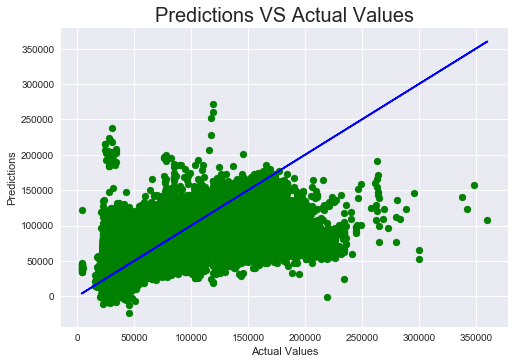

In [117]:
## plot our predicted values versus actaul values
plt.scatter(y_test,y_pred,color='g')
plt.plot(y_test,y_test,color='b')
plt.title('Predictions VS Actual Values',fontsize=20)
plt.xlabel("Actual Values")
plt.ylabel("Predictions")

Text(0.5, 0, 'Distribution')

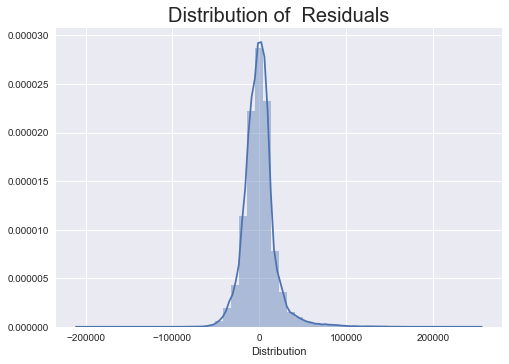

In [118]:
# distribution of residual
sns.distplot(y_test-y_pred)
plt.title('Distribution of  Residuals', fontsize=20)
plt.xlabel('Distribution')

((array([-4.61072808, -4.42286748, -4.32104894, ...,  4.32104894,
          4.42286748,  4.61072808]),
  array([-207875.07915717, -195186.92321323, -191338.2867332 , ...,
          234940.65083325,  247351.55615856,  252984.44474483])),
 (17596.16055016476, -7.0232052289298394, 0.948271984381705))

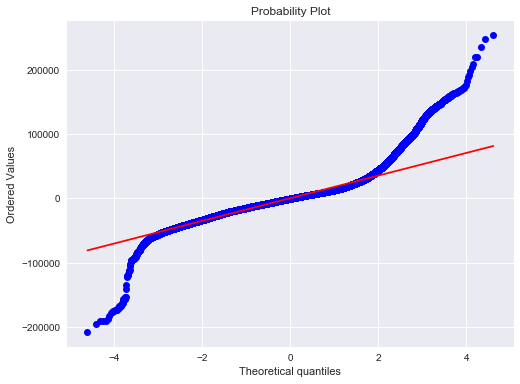

In [119]:
# probability plot, as we can see from this probabiltyplot the values are normal for a 
# time but then skew a lot at the ends
pred_val = y_pred
true_val = y_test
residual = true_val - pred_val

fig, ax = plt.subplots(figsize=(8,6))
sp.stats.probplot(residual, plot=ax, fit=True)